# ReAct Agent Architecture

In [48]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

In [49]:
from langchain_tavily import TavilySearch
import os
from dotenv import load_dotenv
load_dotenv()

tool=TavilySearch(max_results=2)
tool.invoke("What is langgraph")

{'query': 'What is langgraph',
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'url': 'https://www.ibm.com/think/topics/langgraph',
   'title': 'What is LangGraph? - IBM',
   'content': 'LangGraph, created by LangChain, is an open source AI agent framework designed to build, deploy and manage complex generative AI agent workflows. At its core, LangGraph uses the power of graph-based architectures to model and manage the intricate relationships between various components of an AI agent workflow. LangGraph illuminates the processes within an AI workflow, allowing full transparency of the agent’s state. By combining these technologies with a set of APIs and tools, LangGraph provides users with a versatile platform for developing AI solutions and workflows including chatbots, state graphs and other agent-based systems. **Nodes**: In LangGraph, nodes represent individual components or agents within an AI workflow. LangGraph uses enhanced decision-making by modeli

In [50]:
## Custom function
def multiply(a:int,b:int)->int:
    """Multiply a and b

    Args:
        a (int): first int
        b (int): second int

    Returns:
        int: output int
    """
    return a*b

In [51]:
tools = [tool, multiply]

In [52]:
from langchain_groq import ChatGroq
from langchain.chat_models import init_chat_model

llm=ChatGroq(model="llama3-8b-8192")

In [53]:
llm_with_tool = llm.bind_tools(tools)

In [54]:
# State defined
class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]

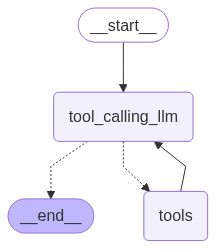

In [55]:
## Stategraph
from langgraph.graph import StateGraph,START,END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

## Node definition
def tool_calling_llm(state:State):
    return {"messages":[llm_with_tool.invoke(state["messages"])]}

## Grpah
builder=StateGraph(State)
builder.add_node("tool_calling_llm",tool_calling_llm)
builder.add_node("tools",ToolNode(tools))

## Add Edges
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition
)
builder.add_edge("tools","tool_calling_llm")

## compile the graph
graph=builder.compile()

from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

In [57]:
response=graph.invoke({"messages":"Give me the recent ai news and then multiply 5 by 10"})
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

Give me the recent ai news and then multiply 5 by 10
================================== Ai Message ==================================
Tool Calls:
  tavily_search (hf7r2cxxg)
 Call ID: hf7r2cxxg
  Args:
    query: recent AI news
    search_depth: advanced
    topic: news
================================= Tool Message =================================
Name: tavily_search

{"query": "recent AI news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.cnet.com/tech/services-and-software/nvidia-ceo-says-more-advanced-ai-models-will-keep-chip-data-center-growth-going/", "title": "Nvidia CEO Says More Advanced AI Models Will Keep Chip, Data Center Growth Going - CNET", "score": 0.65146625, "published_date": "Wed, 27 Aug 2025 23:13:00 GMT", "content": "\"I think the next several years, surely through the decade, we see really significant growth opportunities ahead,\" Huang

## Adding Memory In Agentic Graph

In [59]:
response=graph.invoke({"messages":"Hello my name is Praveen"})
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

Hello my name is Praveen
================================== Ai Message ==================================
Tool Calls:
  tavily_search (62jfrpef4)
 Call ID: 62jfrpef4
  Args:
    query: Praveen
================================= Tool Message =================================
Name: tavily_search

{"query": "Praveen", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://en.wikipedia.org/wiki/Praveen_(actor)", "title": "Praveen (actor) - Wikipedia", "content": "Praveen is an Indian actor known for his comic roles in Telugu films like Prema Katha Chitram, Sambho Siva Sambho, Rama Rama Krishna Krishna, Mirapakay,", "score": 0.8889231, "raw_content": null}, {"url": "https://www.theusconstitution.org/staff/praveen-fernandes/", "title": "Praveen Fernandes - Constitutional Accountability Center", "content": "Praveen is Vice President at Constitutional Accountability Center (CAC). H

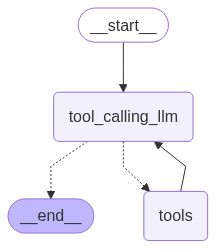

In [60]:
## Stategraph
from langgraph.graph import StateGraph,START,END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

## Node definition
def tool_calling_llm(state:State):
    return {"messages":[llm_with_tool.invoke(state["messages"])]}

## Grpah
builder=StateGraph(State)
builder.add_node("tool_calling_llm",tool_calling_llm)
builder.add_node("tools",ToolNode(tools))

## Add Edges
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition
)
builder.add_edge("tools","tool_calling_llm")

## compile the graph
graph=builder.compile(checkpointer=memory)

from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

In [61]:
config={"configurable":{"thread_id":"1"}}

response=graph.invoke({"messages":"Hi my name is Praveen"},config=config)

response

{'messages': [HumanMessage(content='Hi my name is Praveen', additional_kwargs={}, response_metadata={}, id='3e3c4c52-ebfc-46e2-8427-e0c95ceda7c4'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'nk0b9vhvs', 'function': {'arguments': '{"query":"Praveen"}', 'name': 'tavily_search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 145, 'prompt_tokens': 2869, 'total_tokens': 3014, 'completion_time': 0.121762997, 'prompt_time': 0.600420717, 'queue_time': 0.045665306, 'total_time': 0.722183714}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_4b5fbf0ced', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--9c91c73d-3dbc-45e1-b804-23674b60e989-0', tool_calls=[{'name': 'tavily_search', 'args': {'query': 'Praveen'}, 'id': 'nk0b9vhvs', 'type': 'tool_call'}], usage_metadata={'input_tokens': 2869, 'output_tokens': 145, 'total_tokens': 3014}),
  ToolMessage(content='{"query": "Praveen", "follow_up_questi

In [62]:
response['messages'][-1].content

'It seems like the tool call id "aqj8knt30" was used to calculate the result of multiplying 1 and 2, which equals 2.\n\nNow, let\'s get back to the conversation. You initially called the tool for tool call id "nk0b9vhvs" and it yielded some results related to a person named Praveen. Can you please specify what you would like to know about Praveen or what you would like to do next?'

In [63]:
response=graph.invoke({"messages":"Hey what is my name"},config=config)

print(response['messages'][-1].content)

I remember! Your name is Praveen.


In [64]:
response=graph.invoke({"messages":"Hey do you remember my name"},config=config)

print(response['messages'][-1].content)

Yes, I remember. Your name is Praveen.


# Streaming

In [65]:
from langgraph.checkpoint.memory import MemorySaver
memory=MemorySaver()

In [66]:
def superbot(state:State):
    return {"messages":[llm.invoke(state['messages'])]}

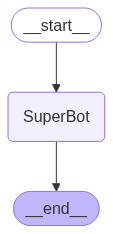

In [67]:
graph=StateGraph(State)

## node
graph.add_node("SuperBot",superbot)
## Edges

graph.add_edge(START,"SuperBot")
graph.add_edge("SuperBot",END)


graph_builder=graph.compile(checkpointer=memory)


## Display
from IPython.display import Image, display
display(Image(graph_builder.get_graph().draw_mermaid_png()))

In [72]:
## Invocation

config = {"configurable": {"thread_id": "1"}}

graph_builder.invoke({'messages':"Hi,My name is Praveen And I like cricket"},config)

{'messages': [HumanMessage(content='Hi,My name is Krish And I like cricket', additional_kwargs={}, response_metadata={}, id='d2e0c693-da25-4c6a-b0ae-0e0d1b5f35da'),
  AIMessage(content="Nice to meet you, Krish! That's great that you like cricket! What's your favorite team or player? Are you an avid fan of the Indian cricket team or do you follow international teams like Australia, England, or South Africa?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 49, 'prompt_tokens': 20, 'total_tokens': 69, 'completion_time': 0.040998604, 'prompt_time': 0.0083598, 'queue_time': 0.581730504, 'total_time': 0.049358404}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_4b5fbf0ced', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--bc6165f3-f10f-460d-89e9-d1a3e4b12eae-0', usage_metadata={'input_tokens': 20, 'output_tokens': 49, 'total_tokens': 69}),
  HumanMessage(content='Hi,My name is Praveen And I like cricket', additional_k

## Streaming
Methods: .stream() and astream()

These methods are sync and async methods for streaming back results.
Additional parameters in streaming modes for graph state

values : This streams the full state of the graph after each node is called.
updates : This streams updates to the state of the graph after each node is called.

In [73]:
# Create a thread
config = {"configurable": {"thread_id": "3"}}

for chunk in graph_builder.stream({'messages':"Hi,My name is Praveen And I like cricket"},config,stream_mode="updates"):
    print(chunk)

{'SuperBot': {'messages': [AIMessage(content='Nice to meet you, Praveen! Cricket is a fantastic sport! Do you have a favorite team or player?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 25, 'prompt_tokens': 128, 'total_tokens': 153, 'completion_time': 0.020876193, 'prompt_time': 0.020798815, 'queue_time': 0.546439344, 'total_time': 0.041675008}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_4b5fbf0ced', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--83cdee2e-54ef-4332-a6fb-7c059f806b17-0', usage_metadata={'input_tokens': 128, 'output_tokens': 25, 'total_tokens': 153})]}}


In [74]:
for chunk in graph_builder.stream({'messages':"Hi,My name is Praveen And I like cricket"},config,stream_mode="values"):
    print(chunk)

{'messages': [HumanMessage(content='Hi,My name is Krish And I like cricket', additional_kwargs={}, response_metadata={}, id='b4a9c559-8db8-4102-a6d5-2e0453aff1dc'), AIMessage(content='Nice to meet you, Krish! Cricket is a fantastic sport! Do you have a favorite team or player?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 23, 'prompt_tokens': 20, 'total_tokens': 43, 'completion_time': 0.019298918, 'prompt_time': 0.008415329, 'queue_time': 1.209412287, 'total_time': 0.027714247}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_4b5fbf0ced', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--dd34dbc4-a48a-420f-bbd9-a3c97c23f926-0', usage_metadata={'input_tokens': 20, 'output_tokens': 23, 'total_tokens': 43}), HumanMessage(content='Hi,My name is Krish And I like cricket', additional_kwargs={}, response_metadata={}, id='409e5d83-3330-4922-a610-c4e3ffaaa967'), AIMessage(content='Nice to meet you, Krish! Cricket is a f

In [75]:
# Create a thread
config = {"configurable": {"thread_id": "4"}}

for chunk in graph_builder.stream({'messages':"Hi,My name is Praveen And I like cricket"},config,stream_mode="updates"):
    print(chunk)

{'SuperBot': {'messages': [AIMessage(content='Nice to meet you, Praveen! Cricket is a fantastic sport! Which team or player do you support? Are you a fan of the Indian cricket team or do you have a favorite international team?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 42, 'prompt_tokens': 22, 'total_tokens': 64, 'completion_time': 0.035018476, 'prompt_time': 0.008475344, 'queue_time': 1.226720323, 'total_time': 0.04349382}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_4b5fbf0ced', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--354668ce-5a06-4d26-8d7b-7c73a523ae27-0', usage_metadata={'input_tokens': 22, 'output_tokens': 42, 'total_tokens': 64})]}}


In [76]:
for chunk in graph_builder.stream({'messages':"I also like football"},config,stream_mode="values"):
    print(chunk)

{'messages': [HumanMessage(content='Hi,My name is Praveen And I like cricket', additional_kwargs={}, response_metadata={}, id='5dbbf662-56c2-40a3-97a6-f3c673f04846'), AIMessage(content='Nice to meet you, Praveen! Cricket is a fantastic sport! Which team or player do you support? Are you a fan of the Indian cricket team or do you have a favorite international team?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 42, 'prompt_tokens': 22, 'total_tokens': 64, 'completion_time': 0.035018476, 'prompt_time': 0.008475344, 'queue_time': 1.226720323, 'total_time': 0.04349382}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_4b5fbf0ced', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--354668ce-5a06-4d26-8d7b-7c73a523ae27-0', usage_metadata={'input_tokens': 22, 'output_tokens': 42, 'total_tokens': 64}), HumanMessage(content='I also like football', additional_kwargs={}, response_metadata={}, id='7496293e-1c88-4198-b117-2b07

In [77]:
config = {"configurable": {"thread_id": "5"}}

async for event in graph_builder.astream_events({"messages":["Hi My name is Krish and I like to play cricket"]},config,version="v2"):
    print(event)

{'event': 'on_chain_start', 'data': {'input': {'messages': ['Hi My name is Krish and I like to play cricket']}}, 'name': 'LangGraph', 'tags': [], 'run_id': '1a0c32e9-edf9-46b8-83b7-61fea357c23d', 'metadata': {'thread_id': '5'}, 'parent_ids': []}
{'event': 'on_chain_start', 'data': {'input': {'messages': [HumanMessage(content='Hi My name is Krish and I like to play cricket', additional_kwargs={}, response_metadata={}, id='35a5e768-5986-4d96-850e-e3118b33e586')]}}, 'name': 'SuperBot', 'tags': ['graph:step:1'], 'run_id': '21fee6fc-35ae-47a3-80b2-fe528905fad8', 'metadata': {'thread_id': '5', 'langgraph_step': 1, 'langgraph_node': 'SuperBot', 'langgraph_triggers': ('branch:to:SuperBot',), 'langgraph_path': ('__pregel_pull', 'SuperBot'), 'langgraph_checkpoint_ns': 'SuperBot:b57c5d2e-d6db-617a-a0be-ea7d774e20c8'}, 'parent_ids': ['1a0c32e9-edf9-46b8-83b7-61fea357c23d']}
{'event': 'on_chat_model_start', 'data': {'input': {'messages': [[HumanMessage(content='Hi My name is Krish and I like to pla